# Imports

In [19]:
# import the used libraries
import numpy as np  
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns   ;   sns.set_style("whitegrid")
from tqdm.notebook import trange, tqdm_notebook ; tqdm_notebook.pandas()
from math import floor, ceil
import gc
import datetime 
from numba import njit
from time import perf_counter

import importlib
import CVA_Module ; importlib.reload(CVA_Module)

# Set general font size and Chart Dimentions
plt.rcParams["figure.autolayout"] = True 
plt.rcParams['font.size']       = '18'
CHART_DIMENTIONS_SINGLE_CHART   = (20,7) 
CHART_DIMENTIONS_DOUBLE_CHART   = (20,11) 
SAVE_CHARTS                     = True 

In [20]:
""" 
Before we begin the Calculation we need to descide to some 'Global' paramters that will be used throughout the calculation 
"""
# Assumed Market Parameters:
a       = 0.01                          # speed of the mean-inversion
sigma   = 0.01                          # Volatility (from spot rates)

# IRS Parameters:
Fixed_rate                  = None      # When None the Fixed rate will equal the Swap Rate ; Set Fixed Rate when calculating CVA for existing IRS
T                           = 30        # End of Simulation and duration of Swap - max T = rates_df max T = 30Y
fixed_payments_frequency    = 3/12      # Can only be 3/12
floating_payments_frequency = 6/12      # Can be 3/12 or 6/12

# Simulation Parameters:
dt      = 1/52                           # 1/12 or 1/52 or 1/256
paths   = 10_000                          # Use between 1_000 and 5_000

t_array = np.arange(start=0, stop=T+dt, step=dt)
CVA = CVA_Module.CVA(CHART_DIMENTIONS_SINGLE_CHART=CHART_DIMENTIONS_SINGLE_CHART) # initialize CVA Object to be used

print(f'>>dt = {dt:.3f} or {dt*365:.2f}days')

>>dt = 0.019 or 7.02days


# Step 1: Loading Euribor and Eunia Data

>>Step (1): Load last available curves and interpolate them to desired frequency


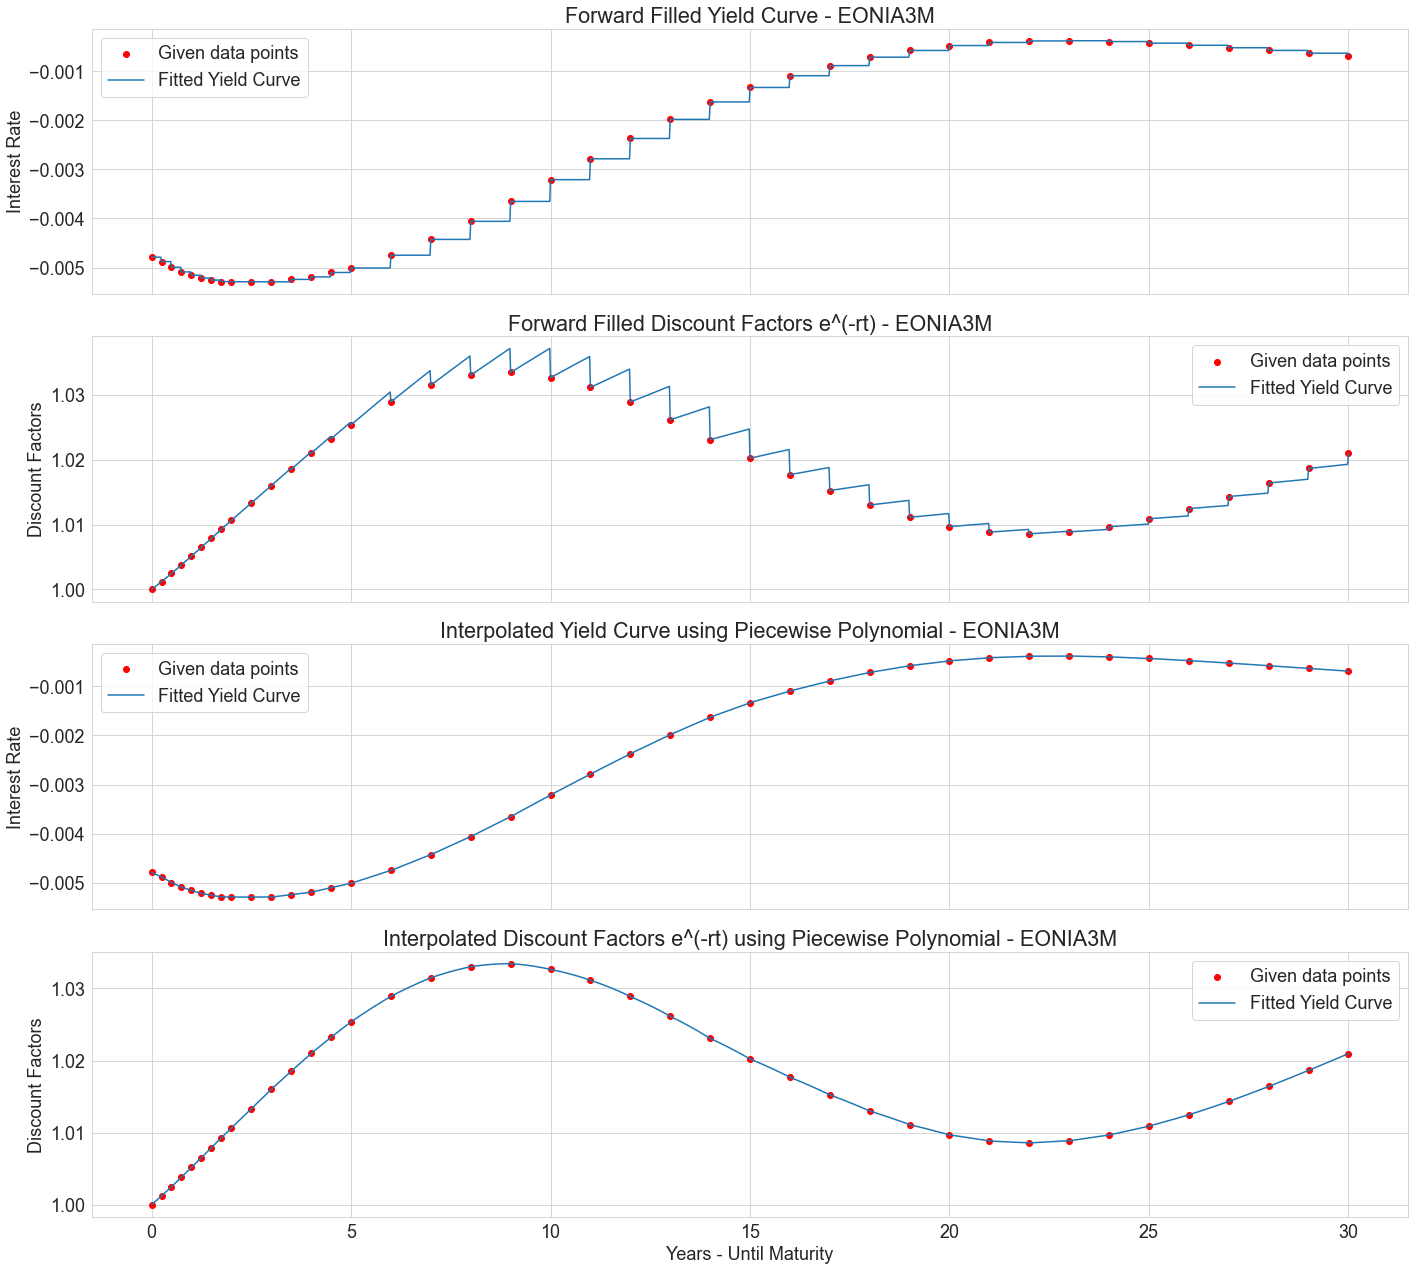

In [21]:
""" Step (1): Load last available curves and interpolate them to desired frequency """
print('>>Step (1): Load last available curves and interpolate them to desired frequency')
df_eonia3m = pd.DataFrame(np.load('data/std_tenor_eonia.npy', allow_pickle=True), columns=['timestamp', 'tenor','rate'])
df_eonia3m.set_index(['timestamp', 'tenor'], inplace=True) ; df_eonia3m.sort_index(level=0, inplace=True)
df_eur3m = pd.DataFrame(np.load('data/std_tenor_eur3m.npy', allow_pickle=True), columns=['timestamp', 'tenor','rate'])
df_eur3m.set_index(['timestamp', 'tenor'], inplace=True)   ; df_eur3m.sort_index(level=0, inplace=True)
df_eur6m = pd.DataFrame(np.load('data/std_tenor_eur6m.npy', allow_pickle=True), columns=['timestamp', 'tenor','rate'])
df_eur6m.set_index(['timestamp', 'tenor'], inplace=True)   ; df_eur6m.sort_index(level=0, inplace=True)

df_eur3m_lastIdx   = df_eur3m.loc[df_eur3m.index.get_level_values(0)==df_eur3m.index.get_level_values(0).max()]
df_eur6m_lastIdx   = df_eur6m.loc[df_eur6m.index.get_level_values(0)==df_eur6m.index.get_level_values(0).max()]
df_eonia3m_lastIdx = df_eonia3m.loc[df_eonia3m.index.get_level_values(0)==df_eonia3m.index.get_level_values(0).max()]

df_eur3m_last   = CVA.get_interpolated_interest_rates(df_eur3m_lastIdx, frequency=dt)
df_eur6m_last   = CVA.get_interpolated_interest_rates(df_eur6m_lastIdx, frequency=dt)
df_eonia3m_last = CVA.get_interpolated_interest_rates(df_eonia3m_lastIdx, frequency=dt)

""" 
--------------------------------------------------------------------------------------------------------------------------------------
Figure: Show Data Generated 
"""
CVA.get_interpolated_interest_rates(df_eonia3m, frequency=dt, _print='EONIA3M')
if SAVE_CHARTS: plt.savefig('Charts/1. Interpolated Interest Rates.pdf')

# Step 2: Simulate Short Rates Using Hull White Monte Carlo Simulation
$$ r(t)=r(s)e^{-a*(t-s)}+ g(t)-g(s)e^{-a*(t-s)}+\sigma\int_{s}^{t}e^{-k(t-s)}dW^0(u) $$
Where, 
$$ g(t) = f(0,t)+\frac{\sigma^2}{2a^2}(1-e^{-at})^2 $$
and $a, \sigma $ are constants

Intrabank short rate 3m: shape = (10000, 1561)
Intrabank short rate 6m: shape = (10000, 1561)
RFR short rate 3m:       shape = (10000, 1561)
a = 0.01, sigma = 0.01, r_0 = -0.0055, T = 30
intervals: 1560 
Total Points: 4680000
paths: 3000 
dt:  0.019230769230769232
hw.shape=(3000, 1561), g_t.shape=(1561,), t.shape=(1561,)

>>Time to simulate: 0.590sec



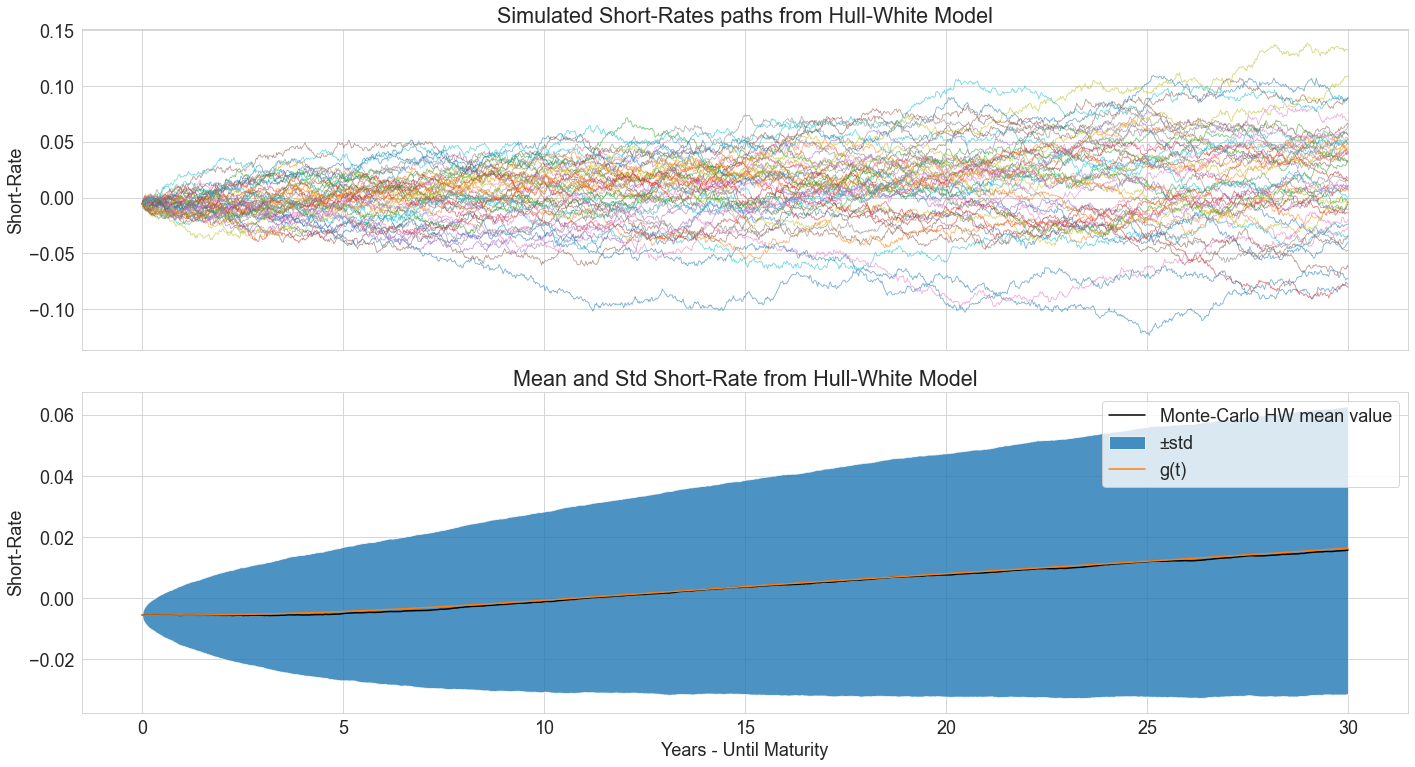

In [22]:
""" Step (2): Simulate Short Rates """
intrabank_short_rate_3m     = CVA.get_short_rate_HW(T=T, a=a, sigma=sigma, dt=dt, paths=paths, rates_df=df_eur3m_last)
intrabank_short_rate_6m     = CVA.get_short_rate_HW(T=T, a=a, sigma=sigma, dt=dt, paths=paths, rates_df=df_eur6m_last)
rfr_short_rate_3m           = CVA.get_short_rate_HW(T=T, a=a, sigma=sigma, dt=dt, paths=paths, rates_df=df_eonia3m_last)
print(f'Intrabank short rate 3m: shape = {intrabank_short_rate_3m.shape}')
print(f'Intrabank short rate 6m: shape = {intrabank_short_rate_6m.shape}')
print(f'RFR short rate 3m:       shape = {rfr_short_rate_3m.shape}')

""" 
--------------------------------------------------------------------------------------------------------------------------------------
Figure: Show MC generated short rate paths 
-> Play with paramteres of 'get_short_rate_HW' funciton to see how it affects the simulation 
"""
hw_r_t, g_t = CVA.get_short_rate_HW(T=T, a=a, sigma=sigma, dt=dt, paths=3_000, rates_df=df_eur3m_last, _print=True)

fig, axs = plt.subplots(2, sharex=True)
index = np.linspace(start=0, stop=T, num=hw_r_t.T.shape[0], endpoint=True)
hv = pd.DataFrame(hw_r_t.T, index=index)
hv.sample(50, axis=1).plot(alpha=.6, lw=.8, legend=False, title='Simulated Short-Rates paths from Hull-White Model', grid=True, ax=axs[0])
hv.mean(axis=1).plot(figsize=CHART_DIMENTIONS_DOUBLE_CHART,legend=False, title='Mean and Std Short-Rate from Hull-White Model', grid=True, ax=axs[1], color='black')
axs[1].fill_between(hv.index.values, hv.mean(axis=1)-hv.std(axis=1), hv.mean(axis=1)+hv.std(axis=1), alpha=.8)
axs[1].plot(index, g_t,'tab:orange')
axs[1].legend(['Monte-Carlo HW mean value', '±std', 'g(t)']) ; axs[1].set_xlabel('Years - Until Maturity') ; axs[1].set_ylabel('Short-Rate') ; axs[0].set_ylabel('Short-Rate')
gc.collect();print()

if SAVE_CHARTS: plt.savefig('Charts/2. Hull-White MC Paths.pdf')

# Step 3: Calucate Discounted Factors for future payments - Both Euribor and Eonia
$$ P(t,T)=\frac{P(0,T)}{P(0,t)}exp\left\{ B(t,T)f(0,t)-\frac{\sigma^2}{4\alpha}B^2(t,T)(1-e^{-2at})-B(t,T)r(t)\right\} $$
Where,
$$ B(t,T)=\frac{1}{a}\big(1-e^{-a(T-t)} \big) $$

Step (3.1): Calucate Discounted Factors for future fixed payments


  0%|          | 0/1561 [00:00<?, ?it/s]

Step (3.2): Calucate Discounted Factors for future floating payments


  0%|          | 0/1561 [00:00<?, ?it/s]

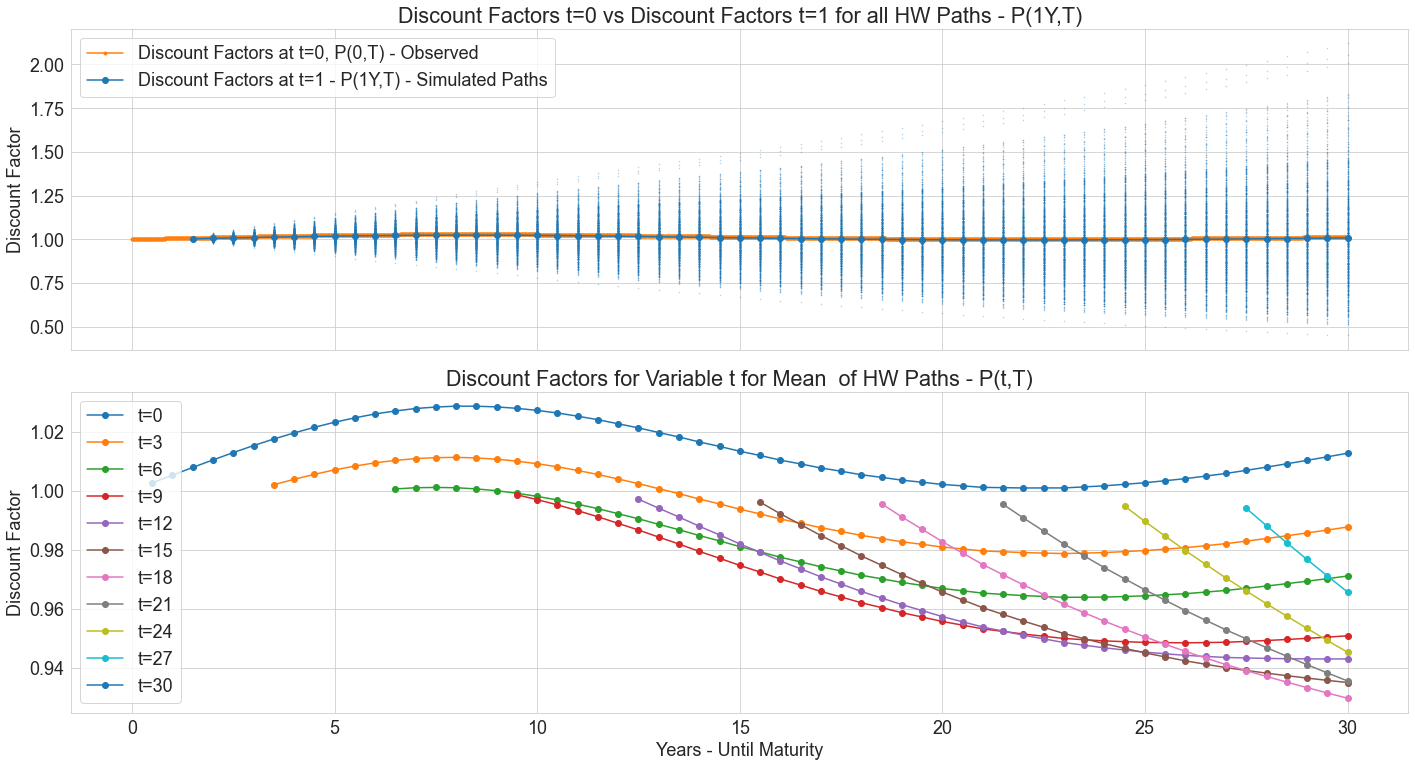

In [5]:
rfr_fixed_P_t_T_list = []   ;   rfr_float_P_t_T_list = []   ;   print(f'Step (3.1): Calucate Discounted Factors for future fixed payments')
for t in tqdm_notebook(t_array):
    rfr_P_t_T_array         = \
        CVA.discount_factor_for_future_payments(df_eonia3m_last, rfr_short_rate_3m , t=t, T=T, payment_frequency=fixed_payments_frequency, 
                                                    dt=dt, alpha=a, sigma=sigma, return_t=False)                                                
    rfr_fixed_P_t_T_list.append(rfr_P_t_T_array)
    if floating_payments_frequency != fixed_payments_frequency:
        rfr_P_t_T_array         = \
            CVA.discount_factor_for_future_payments(df_eonia3m_last, rfr_short_rate_3m , t=t, T=T, payment_frequency=floating_payments_frequency, 
                                                        dt=dt, alpha=a, sigma=sigma, return_t=False)                                                    
    rfr_float_P_t_T_list.append(rfr_P_t_T_array)


floating_P_t_T_list = []    ;   floating_tenors_list = []   ;   print(f'Step (3.2): Calucate Discounted Factors for future floating payments')
for t in tqdm_notebook(t_array):   
    _df_floating        = df_eur3m_last if floating_payments_frequency==3/12 else df_eur6m_last
    _intrabank_short_r  = intrabank_short_rate_3m if floating_payments_frequency==3/12 else intrabank_short_rate_6m
    floating_P_t_T_array, floating_tenors_array    = \
        CVA.discount_factor_for_future_payments(_df_floating, _intrabank_short_r , t=t, T=T, payment_frequency=floating_payments_frequency, 
                                                    dt=dt, alpha=a, sigma=sigma, return_t=True)                                                    
    floating_P_t_T_list.append(floating_P_t_T_array)
    floating_tenors_list.append(floating_tenors_array)

""" 
--------------------------------------------------------------------------------------------------------------------------------------
Figure: Show MC generated short rate paths 
-> Play with paramteres of 'get_short_rate_HW' funciton to see how it affects the simulation 
"""
fig, ax = plt.subplots(2, figsize=CHART_DIMENTIONS_DOUBLE_CHART, sharex=True)
# For fixed t - Multiple Paths
_discount_factors_df = np.exp(-_df_floating.iloc[:,0]*_df_floating.index.values)
_P_t_T_array, _tenors = CVA.discount_factor_for_future_payments(_df_floating, _intrabank_short_r , t=1, T=T, \
    payment_frequency=floating_payments_frequency, dt=dt, alpha=a, sigma=sigma, return_t=True, _print=0)

_discount_factors_df.iloc[_discount_factors_df.index<=T].plot(ax=ax[0], marker='.', color='tab:orange')
ax[0].plot(_tenors, _P_t_T_array.mean(axis=0), marker='o', color='tab:blue')
for ii in range(1000): #P_t_T_array.shape[0]):
    ax[0].scatter(_tenors, _P_t_T_array[ii,:], alpha=0.3, s=0.3, color='tab:blue')

ax[0].legend(['Discount Factors at t=0, P(0,T) - Observed', 'Discount Factors at t=1 - P(1Y,T) - Simulated Paths'])
ax[0].set_ylabel('Discount Factor') ; ax[0].set_title('Discount Factors t=0 vs Discount Factors t=1 for all HW Paths - P(1Y,T)') #  ax[0].grid() ;

# Variable t - Mean HW path
legend = []
for i in range(0,len(floating_P_t_T_list), 3*floor(1/dt)):
    legend.append(f't={i*dt:.0f}')
    _shape = floating_P_t_T_list[i].shape[1]
    _x = np.arange(start=0, stop=_shape*floating_payments_frequency, step=floating_payments_frequency)
    _x = floating_tenors_list[i] #+ 2020
    ax[1].plot(_x, floating_P_t_T_list[i].mean(axis=0), marker='o')
    
ax[1].set_title('Discount Factors for Variable t for Mean  of HW Paths - P(t,T)')
ax[1].set_xlabel('Years - Until Maturity') ; ax[1].set_ylabel('Discount Factor')
ax[1].legend(legend) ; gc.collect();print()
if SAVE_CHARTS: plt.savefig('Charts/3. Discounted Factors.pdf')

# Step 4: Covert Euribor Discount Factors to Forward Rates
Froward rate at time t with maturity T:
$$ f(t,T)=-\frac{ln(P(t,T))}{T-t}  $$

>>Step (4): Calculate Forward Rate Curves for floating payments


  0%|          | 0/1561 [00:00<?, ?it/s]

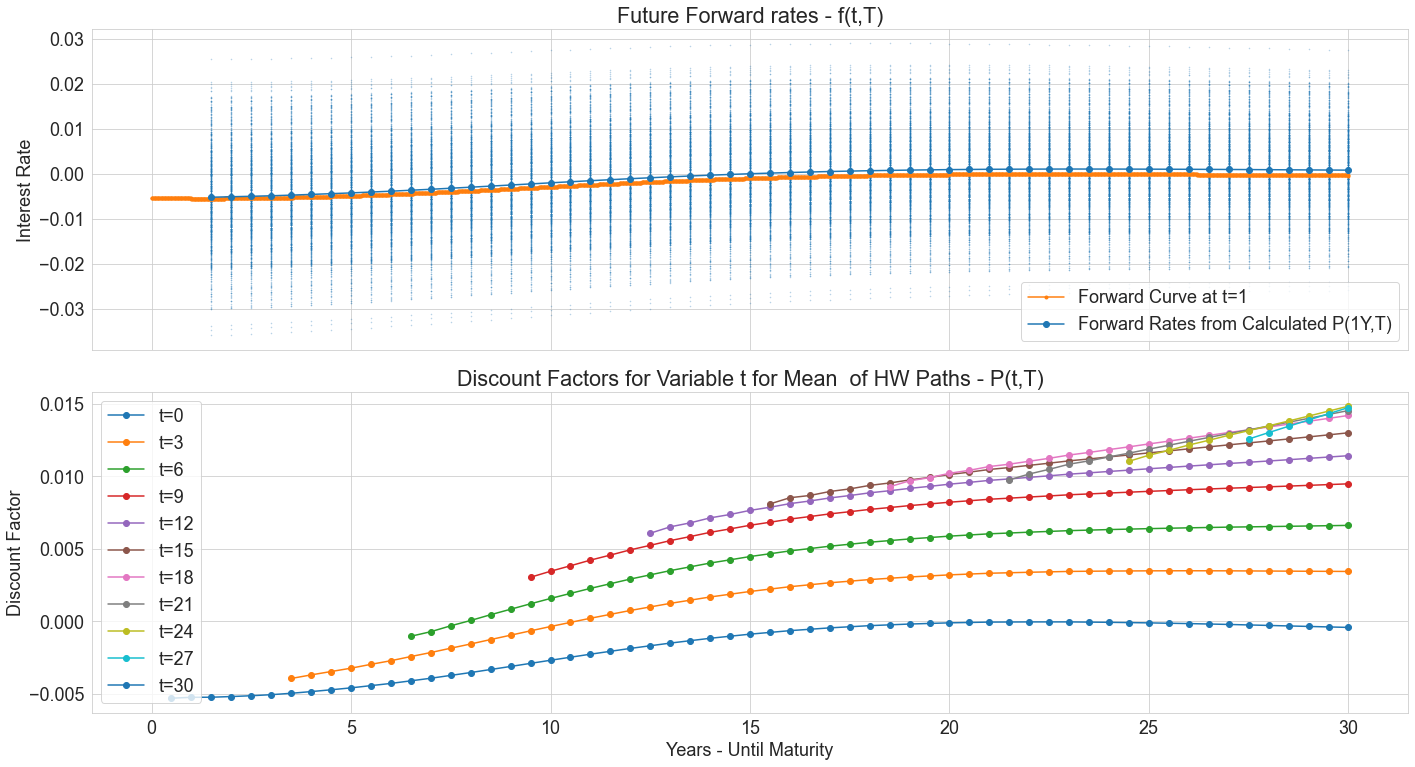

In [6]:
""" Step (4): Calculate Forward Rate """
forward_rate_curves_list = []   ;       print(f'>>Step (4): Calculate Forward Rate Curves for floating payments')
for i in trange(len(floating_P_t_T_list)):
    forward_rate_curve_array = -np.log(floating_P_t_T_list[i]) / (floating_tenors_list[i] - t_array[i])
    forward_rate_curves_list.append(forward_rate_curve_array)
""" 
--------------------------------------------------------------------------------------------------------------------------------------
Figure: Show MC generated short rate paths 
-> Play with paramteres of 'get_short_rate_HW' funciton to see how it affects the simulation 
"""
_forward_rate_curve_array = -np.log(_P_t_T_array) / (_tenors - 1)
fig, ax = plt.subplots(2, figsize=CHART_DIMENTIONS_DOUBLE_CHART, sharex=True)
# For fixed t - Multiple Paths
df_eur3m_last.iloc[df_eur3m_last.index<=T].plot(ax=ax[0], marker='.', color='tab:orange')
ax[0].plot(_tenors, _forward_rate_curve_array.mean(axis=0), marker='o', color='tab:blue')
for ii in range(1000):
    ax[0].scatter(_tenors, _forward_rate_curve_array[ii,:], alpha=0.3, s=0.3, color='tab:blue')

ax[0].legend(['Forward Curve at t=1','Forward Rates from Calculated P(1Y,T)'])
ax[0].set_ylabel('Interest Rate') ; ax[0].set_title('Future Forward rates - f(t,T)') #  ax[0].grid() ;

# # Variable t - Mean HW path
legend = []
for i in range(0,len(forward_rate_curves_list), 3*floor(1/dt)):
    legend.append(f't={i*dt:.0f}')
    _shape = forward_rate_curves_list[i].shape[1]
    _x = np.arange(start=0, stop=_shape*floating_payments_frequency, step=floating_payments_frequency)
    _x = floating_tenors_list[i] #+ 2020
    ax[1].plot(_x, forward_rate_curves_list[i].mean(axis=0), marker='o')
    
ax[1].set_title('Discount Factors for Variable t for Mean  of HW Paths - P(t,T)')
ax[1].set_xlabel('Years - Until Maturity') ; ax[1].set_ylabel('Discount Factor')
ax[1].legend(legend) ;  gc.collect();print() #  ax[1].grid() ;
if SAVE_CHARTS: plt.savefig('Charts/4. Forward Rates.pdf')

# Step 5: Value IRS at time 0 and Revalue IRS at times t
$$ V(t) = \sum NPV_{\text{floating payments}} - \sum NPV_{\text{fixed payments}} $$

Where,

$$ \sum NPV_{\text{floating payments}} =  \sum (Notional * f(t,T) * \text{floating payment frequency}* P(t,T) ) $$
$$ \sum NPV_{\text{fixed payments}}    =  \sum (Notional * \text{Fixed Rate} * \text{fixed payment frequency}* P(t,T) ) $$

And, 
$$ f(t,T) \text{ is the floating rate at time t} $$
$$ P(t,T)\text{ is the RF discount factor at time t} $$

Swap rate = -0.1833%


  0%|          | 0/1561 [00:00<?, ?it/s]

Swap  Rate = -0.18331 %
Sum of the NPV of fixed cashflows = -5.6013
Sum of the NPV of floating cashflows = -5.6013
Interest Rate Swap Value = -0.0000 EUR



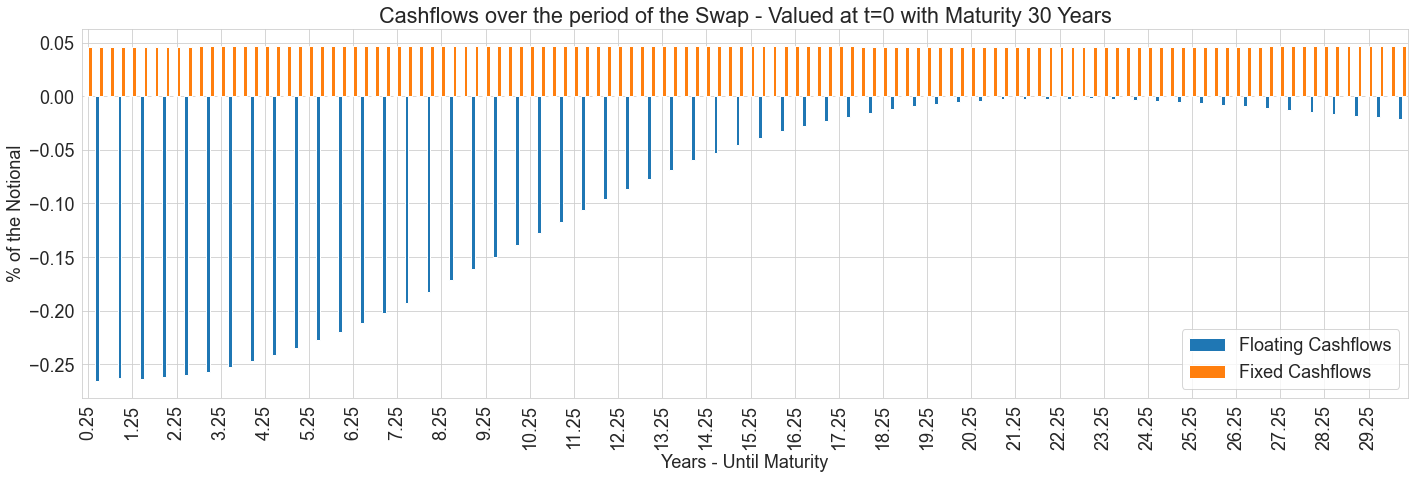

In [7]:
""" Step (5.1) : Find the Swap Rate at time t = 0, with given curves so the Value of the Swap = 0 """
t_floating  = np.arange(start=floating_payments_frequency, stop=T+0.00001, step=floating_payments_frequency)
t_fixed     = np.arange(start=fixed_payments_frequency, stop=T+0.00001, step=fixed_payments_frequency)
forward_rates               = CVA.get_interpolated_interest_rates(df_eur3m_lastIdx if floating_payments_frequency == 3/12 else df_eur6m_lastIdx, frequency=floating_payments_frequency)
discount_factor_floating    = CVA.get_interpolated_interest_rates(df_eonia3m_lastIdx, frequency=floating_payments_frequency)
discount_factor_fixed       = CVA.get_interpolated_interest_rates(df_eonia3m_lastIdx, frequency=fixed_payments_frequency)

discount_factor_floating    = (np.exp(-discount_factor_floating.iloc[:,0]*discount_factor_floating.index.values)).loc[t_floating] #; print(discount_factor_floating)
discount_factor_fixed       = (np.exp(-discount_factor_fixed.iloc[:,0]*discount_factor_fixed.index.values)).loc[t_fixed]

if Fixed_rate: print(f'Fixed rate = {Fixed_rate*100:.4f}')
swap_rate = np.sum(forward_rates.loc[t_floating].values[:,0] * floating_payments_frequency * discount_factor_floating.values) \
     / np.sum(fixed_payments_frequency * discount_factor_fixed.values)
print(f'Swap rate = {swap_rate*100:.4f}%')

""" Step (5.2) : Re evaluate the swap for the given paths """
IRS_value_list = []
for i in tqdm_notebook(range(len(rfr_float_P_t_T_list))):   
    npv_floating, npv_fixed, sum_npv_floating, sum_npv_fix, IRS_value = CVA.interest_rate_swap_valuation_vectorised(
        Notional = 100, 
        Floating_rate = forward_rate_curves_list[i],            # <- vector
        Floating_rate_cashflows_frequency = floating_payments_frequency, 
        RFR_discounted_for_float_list = rfr_float_P_t_T_list[i],  # <- vector
        RFR_discounted_for_fixed_list = rfr_fixed_P_t_T_list[i],  # <- vector
        Fixed_rate = Fixed_rate if Fixed_rate else swap_rate,
        Fixed_rate_cashflows_frequency = fixed_payments_frequency
        )
    IRS_value_list.append(IRS_value * np.exp(-df_eonia3m_last.iloc[i, 0] * i*dt) )

IRS_values_df = pd.DataFrame(IRS_value_list, index=t_array)

""" 
--------------------------------------------------------------------------------------------------------------------------------------
Figure: Show Cashflow Payments over the duration of the Swap 
"""
npv_floating, npv_fixed, sum_npv_floating, sum_npv_fix, IRS_value = CVA.interest_rate_swap_valuation(
    Notional = 100, 
    Floating_rate_df = forward_rates.loc[t_floating].values[:,0], 
    Floating_rate_cashflows_frequency = floating_payments_frequency, 
    RFR_discounted_for_float_df = discount_factor_floating,
    RFR_discounted_for_fixed_df = discount_factor_fixed,
    Fixed_rate = Fixed_rate if Fixed_rate else swap_rate,
    Fixed_rate_cashflows_frequency = fixed_payments_frequency
    )

npv_cashflows = pd.concat([npv_floating, -npv_fixed], axis=1).reset_index(level=0, drop=True)
_dt = floating_payments_frequency if floating_payments_frequency<fixed_payments_frequency else fixed_payments_frequency
npv_cashflows.index = [t+_dt for t in np.arange(0, T, _dt)]
npv_cashflows.columns = ['Floating Cashflows', 'Fixed Cashflows']
npv_cashflows.sort_index(inplace=True)


npv_cashflows.plot.bar(figsize=CHART_DIMENTIONS_SINGLE_CHART, title=f'Cashflows over the period of the Swap - Valued at t=0 with Maturity {T} Years', \
    grid=True, xlabel='Years - Until Maturity', ylabel='% of the Notional', width=0.7)
plt.locator_params(axis='x', nbins=38)

gc.collect()
print(f'Swap  Rate = {swap_rate*100:.5f} %')
print(f'Sum of the NPV of fixed cashflows = {sum_npv_fix:.4f}')
print(f'Sum of the NPV of floating cashflows = {sum_npv_floating:.4f}')
print(f'Interest Rate Swap Value = {IRS_value:.4f} EUR')   ;print()
if SAVE_CHARTS: plt.savefig('Charts/5. Cashflows.pdf')

# Step 6: Calculate Expected Possitive Exposure
$$ EPE(t) = E[V(t)e^{-rt}\text{ | }V(t)>0]$$

/var/folders/57/8q11hb450rz9z_rwvfbzpkmm0000gn/T/ipykernel_38815/433120698.py:4: RuntimeWarning: Mean of empty slice
  _mean = np.nanmean(IRS_values_df.values, axis=1) ; _mean[-1] = 0.0


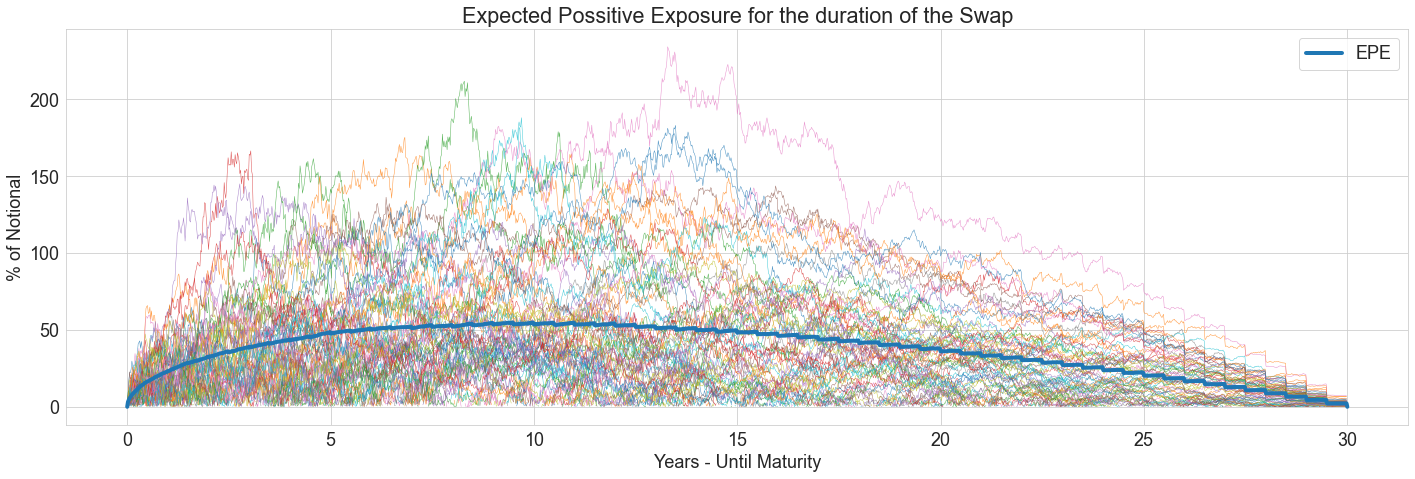

In [8]:
""" Calculate EPE where EE > 0 """
IRS_values_df_values = IRS_values_df.values
IRS_values_df_values[IRS_values_df_values<=0] = np.nan
_mean = np.nanmean(IRS_values_df.values, axis=1) ; _mean[-1] = 0.0 
IRS_values_df = IRS_values_df.assign(EPE=_mean)

""" step (2) : Plot the results of CVA """
fig, axs = plt.subplots(1, figsize=CHART_DIMENTIONS_SINGLE_CHART)
axs.plot(IRS_values_df.index.values, IRS_values_df.sample(100, axis=1).values, alpha=0.8, lw=0.5)
IRS_values_df.EPE.plot(grid=True, title='Expected Possitive Exposure for the duration of the Swap', xlabel='Years - Until Maturity', ylabel='% of Notional', ax=axs, color='tab:blue', lw=4, legend=True) #, marker='o')

gc.collect();print()
if SAVE_CHARTS: plt.savefig('Charts/6. EPE.pdf')

# Step 7: Probability of Default from CDS Data
$$ PD(t) = (spread(t) / LGD) $$
$$ PD(t,\text{| no default before t}) = (1-PD(t-dt)) * PD(t) $$
Where Loss Given Default equals,
$$ LGD = 1 - \text{recovery}$$

>>Loss Given Default = 0.65
>>Recovery = 0.35



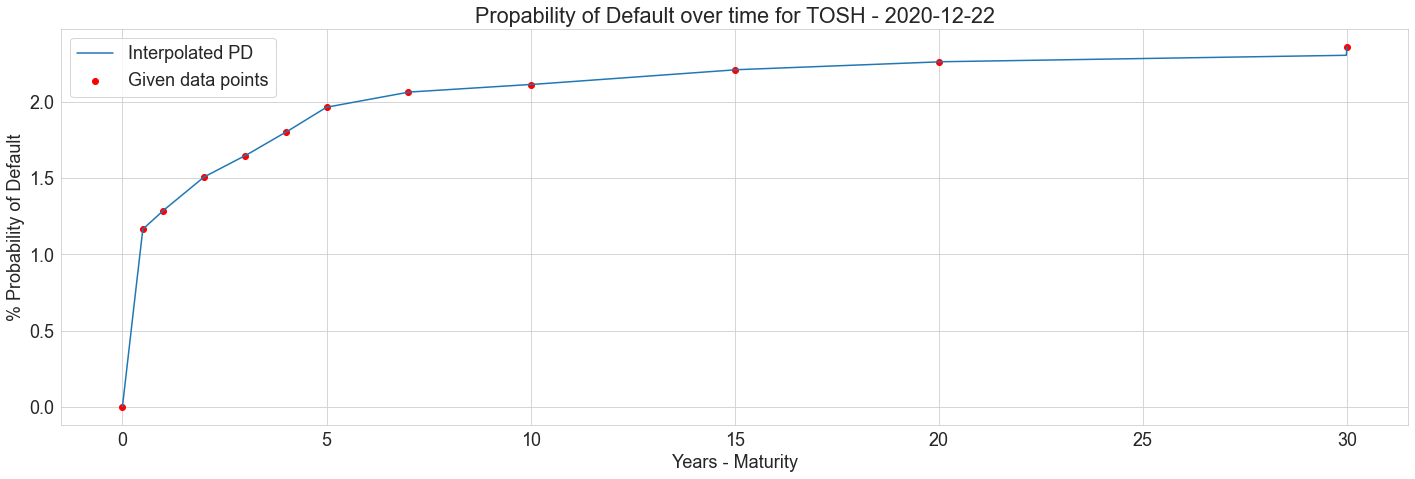

In [9]:
""" Get PD from CDS """
_ticker = 'TOSH'
cds, recovery = CVA.get_rating_cds_interpolated_and_recovery(cds_ticker=_ticker, dt=dt, T=T)
LGD = 1 - recovery ; print(f'>>Loss Given Default = {LGD}')
PD_df = (cds / LGD)

""" Probability of Default for period [t_(i-1) - t_i]"""
PD_df = (1 - PD_df.shift(-1, fill_value=0)) * PD_df

cds, recovery = CVA.get_rating_cds_interpolated_and_recovery(cds_ticker=_ticker, dt=dt, T=T, _print=f'Propability of Default over time for {_ticker} - 2020-12-22')
gc.collect();print()
if SAVE_CHARTS: plt.savefig('Charts/7. Probability of Default.pdf')

# Step 8: CVA value with Standard Error - Using Bootstraping Method
$$CVA = LGD*\sum_{t=0}^{T}EPE(t)*dt * PD(t,\text{| no default before t})$$
Standard Error in CVA calculation:
$$ SE = \frac{\sigma}{\sqrt{n}}$$
$$ CI_{99\%}=\bar{x}±2.576*SE $$
Where, $\sigma$ is the standard deviation of the subsets of the Simulated Paths


and $n$ is the number of the subsets of the Simulated Paths. i.e. Splitting 10,000 paths to 100 subsets of 100 paths each

/var/folders/57/8q11hb450rz9z_rwvfbzpkmm0000gn/T/ipykernel_38815/4232094910.py:8: RuntimeWarning: Mean of empty slice
  _means = np.nanmean(_df, axis=1)


----------------------------------------------------------------
Mean CVA  = 15.06082 % as a percentage of the Notional
SE in CVA = 0.11238 %
----------------------------------------------------------------



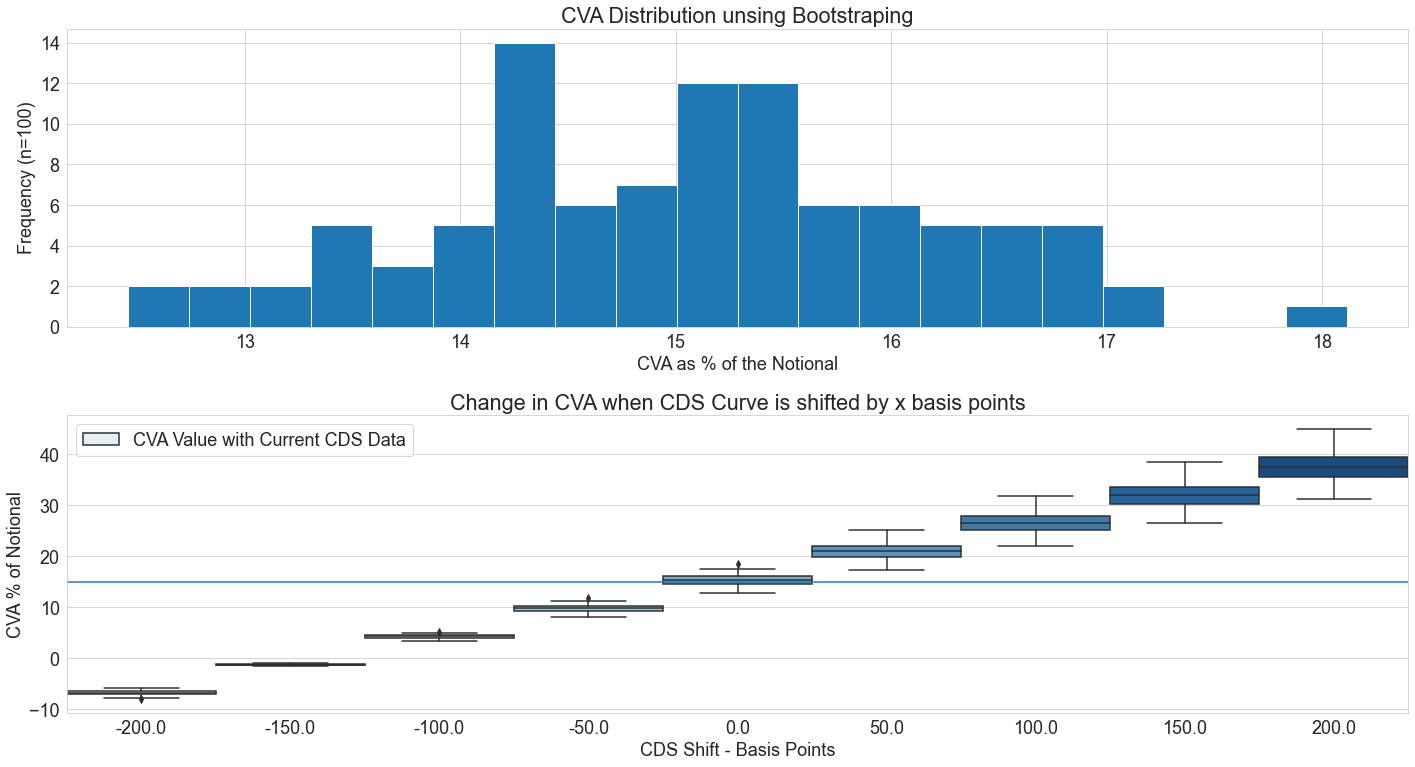

In [10]:
"""  Bootstrap means calculations """
IRS_values_df_cp = IRS_values_df.copy(deep=True)
_n=100 ; dfs = np.array_split(IRS_values_df_cp, _n, axis=1)
LGD = 1 - recovery

means = np.zeros((_n, IRS_values_df_cp.shape[0]))
for _i, _df in enumerate(dfs):
    _means = np.nanmean(_df, axis=1)
    means[_i,:] = _means
means = means.T 

sns.set_style("whitegrid")
fig, axs = plt.subplots(2, figsize=CHART_DIMENTIONS_DOUBLE_CHART)

print('----------------------------------------------------------------')
a = dt * PD_df.copy(deep=True).values
b = means.reshape((IRS_values_df_values.shape[0],-1)) * a.reshape((IRS_values_df_values.shape[0],-1))
CVA_results = LGD * np.nansum(b,axis=0)
axs[0].hist(CVA_results, bins = 20) ; axs[0].set_xlabel('CVA as % of the Notional') ; axs[0].set_ylabel(f'Frequency (n={_n})')
axs[0].set_title('CVA Distribution unsing Bootstraping')
print(f'Mean CVA  = {CVA_results.mean():.5f} % as a percentage of the Notional')
print(f'SE in CVA = {CVA_results.std()/np.sqrt(_n):.5f} %')
print('----------------------------------------------------------------')

cva_shifted = [] ; shift = np.array([-0.02, -0.015,-0.01,-0.005,0,0.005,0.01,0.015,0.02])
for cds_shift in shift:
    _PD_df = ((cds+cds_shift) / LGD)
    a = dt * _PD_df.values
    b = means.reshape((IRS_values_df_values.shape[0],-1)) * a.reshape((IRS_values_df_values.shape[0],-1))
    cva_shifted.append(LGD * np.nansum(b,axis=0))

_CVA_over_shift = pd.DataFrame(cva_shifted)
_CVA_over_shift = _CVA_over_shift.T
_CVA_over_shift.columns = shift*10000
_CVA_over_shift

sns.boxplot(data=_CVA_over_shift, width=1, ax=axs[1], palette="Blues")
axs[1].axhline(CVA_results.mean())
axs[1].legend(['CVA Value with Current CDS Data'])
axs[1].set_title('Change in CVA when CDS Curve is shifted by x basis points')
axs[1].set_xlabel('CDS Shift - Basis Points') ; axs[1].set_ylabel('CVA % of Notional')
gc.collect();print()

if SAVE_CHARTS: plt.savefig('Charts/8. CVA.pdf')

## CVA as a function of T and CDS

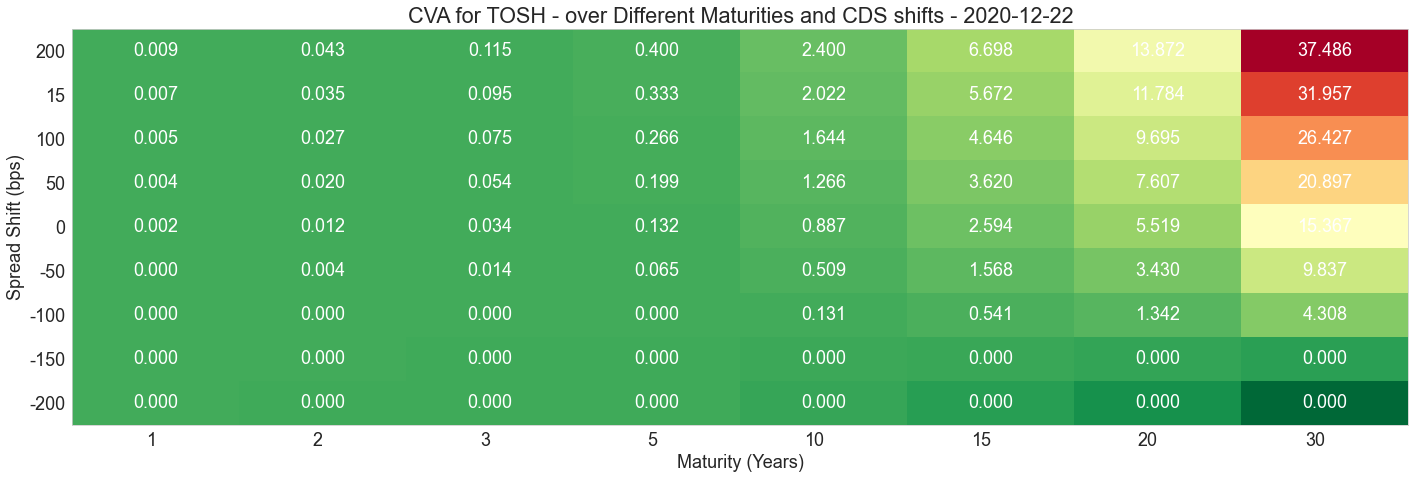

In [11]:
cva_over_cds_spread = np.load('data/CVA over CDS Spread TOSH.npy')

maturities = np.array([1,2,3,5,10,15,20,30])
spread_adj = np.array([-200, -150,-100,-50,0,50,100,15,200])[::-1]

fig, ax = plt.subplots(figsize=CHART_DIMENTIONS_SINGLE_CHART)
im = ax.imshow(-cva_over_cds_spread, cmap='RdYlGn', interpolation='nearest', aspect='auto')

# Show all ticks and label them with the respective list entries
ax.set_yticks(np.arange(len(spread_adj)), labels=spread_adj)
ax.set_xticks(np.arange(len(maturities)), labels=maturities)

plt.setp(ax.get_xticklabels(), ha="right", rotation_mode="anchor")
# Loop over data dimensions and create text annotations.
for i in range(len(maturities)):
    for j in range(len(spread_adj)):
        cva_local_v = cva_over_cds_spread[j, i] if cva_over_cds_spread[j, i] > 0 else 0
        text = ax.text(i, j, f'{cva_local_v:.3f}', ha="center", va="center", color="w")

ax.set_title("CVA for TOSH - over Different Maturities and CDS shifts - 2020-12-22")
plt.xlabel('Maturity (Years)') ; plt.ylabel('Spread Shift (bps)')
plt.grid(False)
if SAVE_CHARTS: plt.savefig('Charts/9. CVA Relative to CDS.pdf')

# Step 7b: CVA when CDS data is missing

>> Rating = AA, Sector = Technology, Region = Europe
Mean 5Y CDS Spread: 46.782, Std: 25.812
Number of samples:  25
Assumed Recovery:  0.4
----------------------------------------------------------------------------
5th Quantile CVA    = 1.4547 % as a percentage of the Notional
Mean CVA            = 5.1848 % as a percentage of the Notional
95th Quantile CVA   = 10.8181 % as a percentage of the Notional
SE in CVA:mean      = 0.0380% | CVA:5thQ = 0.0107% | CVA:95thQ = 0.0793%
----------------------------------------------------------------------------


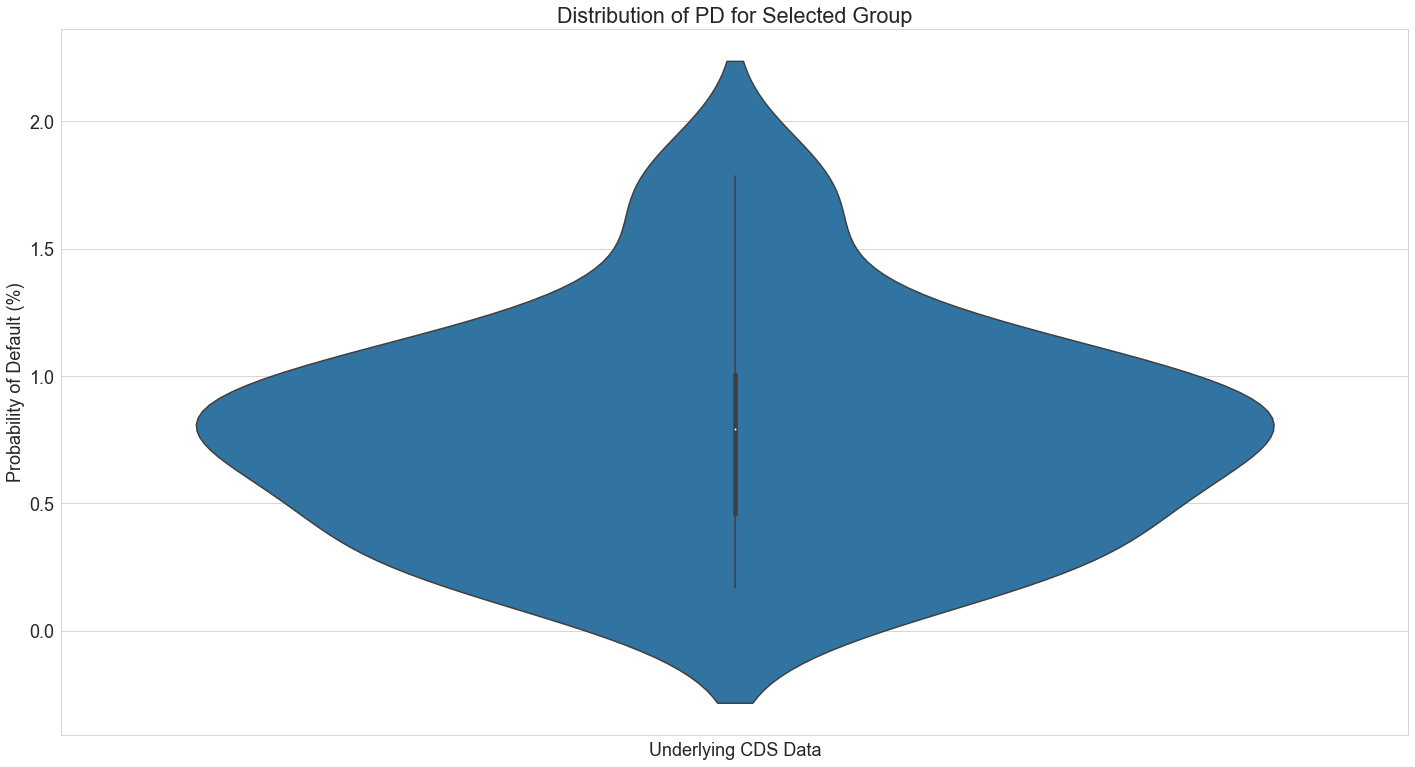

In [12]:
Rating = 'AA'
Sector='Technology'
Region='Europe'
mean_cds, q5_cds, q95_cds, cds_std, samples = CVA.get_pd_estimate(Rating=Rating, Sector=Sector, Region=Region)

assumed_recovery = 0.40 ;   LGD = 1 - assumed_recovery
print(f">> Rating = {Rating}, Sector = {Sector}, Region = {Region}")
print(f'Mean 5Y CDS Spread: {mean_cds:.3f}, Std: {cds_std:.3f}')
print('Number of samples: ', samples)
print('Assumed Recovery: ', assumed_recovery)

mean_pd, q5_pd, q95_pd = (mean_cds/10000 / LGD), (q5_cds/10000 / LGD), (q95_cds/10000 / LGD)

print('----------------------------------------------------------------------------')

CVA_m   = LGD * np.nansum(means.reshape((IRS_values_df_values.shape[0],-1)) * dt * mean_pd,axis=0)
CVA_5   = LGD * np.nansum(means.reshape((IRS_values_df_values.shape[0],-1)) * dt * q5_pd,axis=0)
CVA_95  = LGD * np.nansum(means.reshape((IRS_values_df_values.shape[0],-1)) * dt * q95_pd,axis=0)

print(f'5th Quantile CVA    = {CVA_5.mean():.4f} % as a percentage of the Notional')
print(f'Mean CVA            = {CVA_m.mean():.4f} % as a percentage of the Notional')
print(f'95th Quantile CVA   = {CVA_95.mean():.4f} % as a percentage of the Notional')
print(f'SE in CVA:mean      = {CVA_m.std()/np.sqrt(_n):.4f}% | CVA:5thQ = {CVA_5.std()/np.sqrt(_n):.4f}% | CVA:95thQ = {CVA_95.std()/np.sqrt(_n):.4f}%')
print('----------------------------------------------------------------------------')

cds_df = CVA.get_pd_estimate(Rating=Rating, Sector=Sector, Region=Region, return_df=True)
cds_df = (cds_df/10000 / LGD) * 100
cds_df.columns = ['Underlying CDS Data']

fig, ax = plt.subplots(figsize=CHART_DIMENTIONS_DOUBLE_CHART)
sns.violinplot(data=cds_df, ax=ax)
ax.set_ylabel('Probability of Default (%)') ; ax.set_title('Distribution of PD for Selected Group')
if SAVE_CHARTS: plt.savefig('Charts/7b. CVA without CDS data.pdf')

Unique Rating Values: ['BBB' 'B' 'A' 'BB' 'AA' 'CCC']
Unique Countries    : ['United Kingdom' 'Spain' 'France' 'Italy' 'Germany' 'Netherlands'
 'Belgium' 'Luxembourg' 'Sweden' 'Portugal' 'Ireland' 'Denmark'
 'Switzerland' 'Austria' 'Finland' 'Greece' 'Norway']


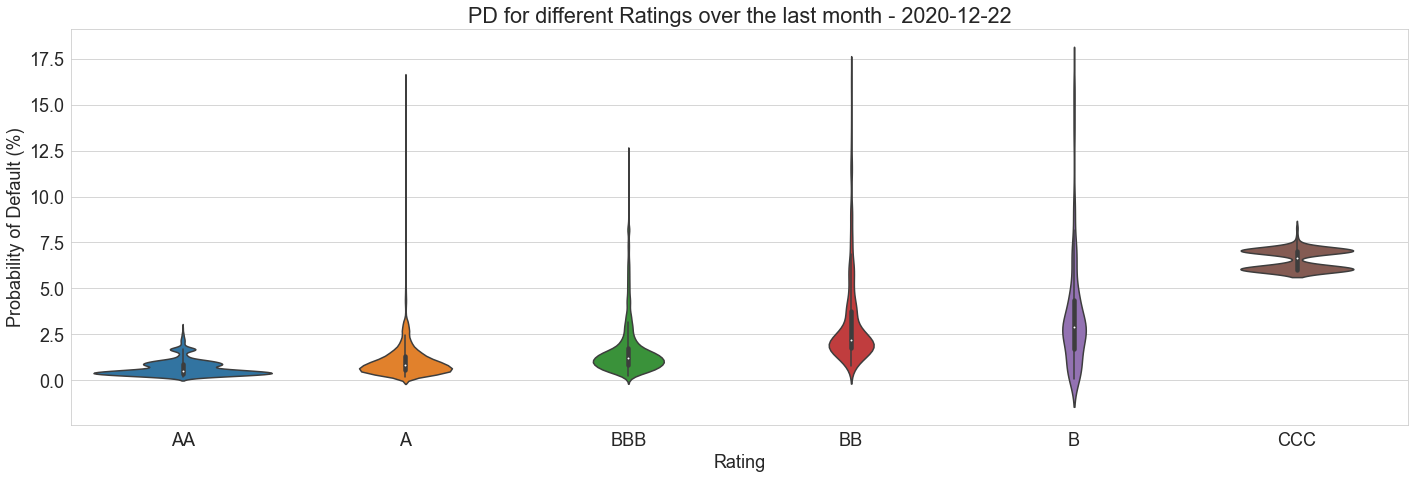

In [13]:
df = pd.read_csv('data/final_dataset.csv') 
df.date = pd.to_datetime(df.date, format='%Y%m%d')
df = df.loc[df.date > df.date.max() - pd.DateOffset(month=1)]
df.cds_spread = (df.cds_spread/10000 / LGD) * 100

print(f'Unique Rating Values: {df.Rating.unique()}')
print(f'Unique Countries    : {df.Country.unique()}')
plt.figure(figsize=(20,7))
sns.violinplot(x='Rating', y='cds_spread', data=df, order=["AA", 'A', 'BBB', 'BB', 'B', 'CCC'])
plt.title('PD for different Ratings over the last month - 2020-12-22') ; plt.ylabel('Probability of Default (%)')

if SAVE_CHARTS: plt.savefig('Charts/7v. CDS for different ratings.pdf')

-------------------------------------------
# Apendix

## EONIA3M vs EURIBOR3M

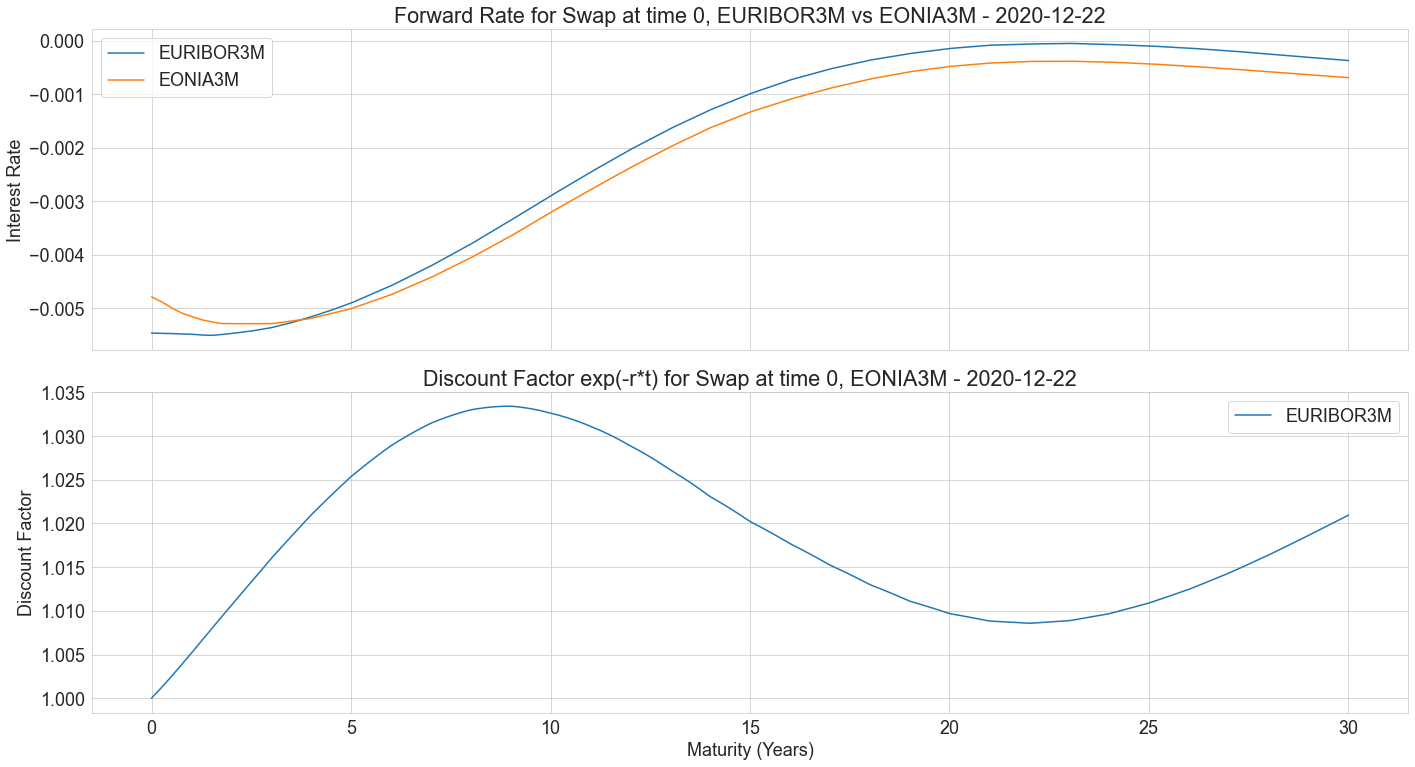

In [14]:
""" Load EONIA - EURIBOR3M - EURIBOR6M data """
fig, axs = plt.subplots(2, figsize=CHART_DIMENTIONS_DOUBLE_CHART, sharex=True)
df_eur3m_last.plot(ax=axs[0])   ;   df_eonia3m_last.plot(ax=axs[0])
axs[0].legend(['EURIBOR3M', 'EONIA3M']) ; axs[0].set_title('Forward Rate for Swap at time 0, EURIBOR3M vs EONIA3M - 2020-12-22')
axs[0].set_ylabel('Interest Rate')

np.exp(-df_eonia3m_last.iloc[:,0]*df_eonia3m_last.index.values).plot(ax=axs[1])
axs[1].legend(['EURIBOR3M', 'EONIA3M']) ; axs[1].set_title('Discount Factor exp(-r*t) for Swap at time 0, EONIA3M - 2020-12-22')
axs[1].set_xlabel('Maturity (Years)') ; axs[1].set_ylabel('Discount Factor')

if SAVE_CHARTS: plt.savefig('Charts/Appendix. Forward rate and Discount Factors.pdf')

## EONIA3M - Forward Curve (2016->2020)

Standard Deviaiton of spot rate = 0.0006844 : Samples(Days) = 1275


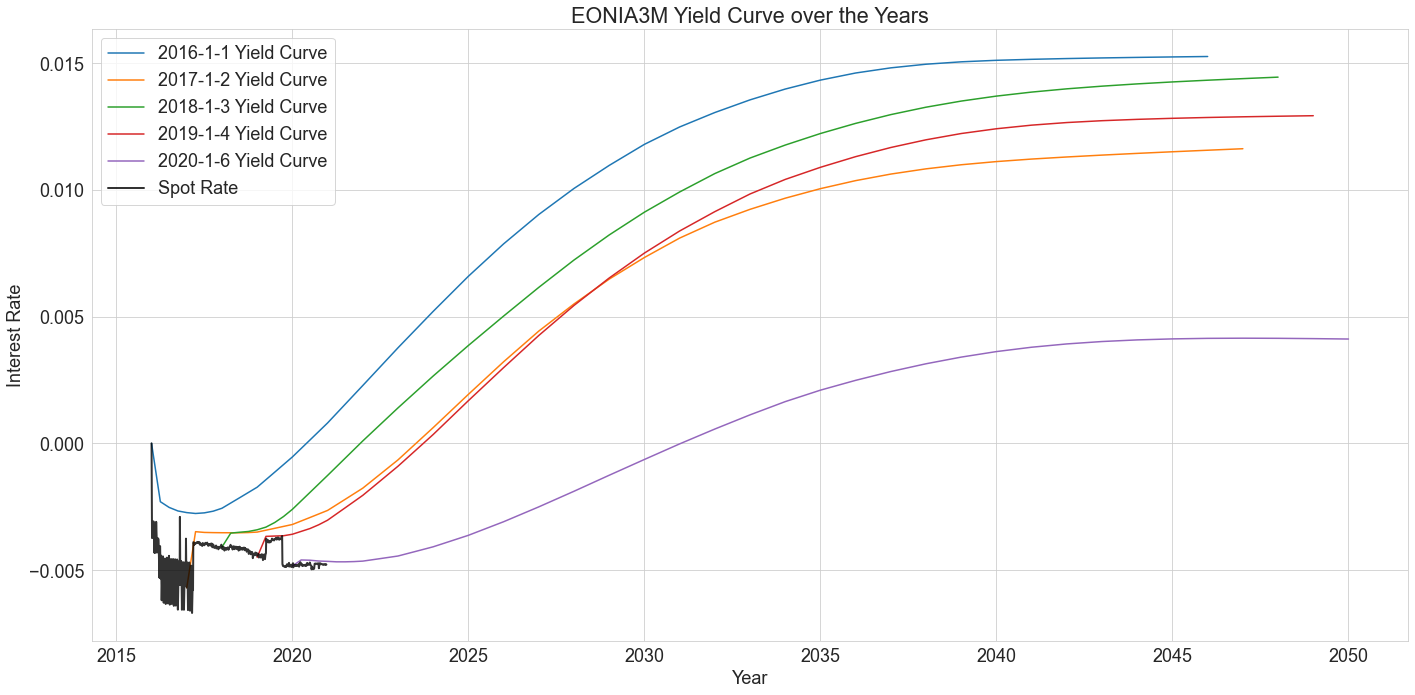

In [15]:
_index_date  = df_eonia3m.index.get_level_values(0)[0]
_index_dates = df_eonia3m.index.get_level_values(0).unique()
fig, ax = plt.subplots()
legend = [f'{_index_date.year}-{_index_date.month}-{_index_date.day} Yield Curve']

_starting_year = 2016
_df = df_eonia3m.loc[df_eonia3m.index.get_level_values(0) == _index_date].reset_index(level=0)
_df.index = _df.index + _starting_year ; _starting_year +=1
_df.plot(title='EONIA3M Yield Curve over the Years', figsize=(20,10), grid=True, ax=ax)

for id in _index_dates:
    if id - _index_date > datetime.timedelta(days=365):
        _index_date = id
        legend.append(f'{_index_date.year}-{_index_date.month}-{_index_date.day} Yield Curve')
        _df = df_eonia3m.loc[df_eonia3m.index.get_level_values(0) == _index_date].reset_index(level=0)
        _df.index = _df.index + _starting_year ; _starting_year +=1
        ax.plot(_df.index.values, _df.values[:,1])

_df2 = df_eonia3m.loc[df_eonia3m.index.get_level_values(1) == 0].reset_index(level=1)['rate']
ax.plot((2016 - pd.Series(datetime.date(2016,1,1) - _df2.index.values).dt.days.values/365)[slice(None,None,3)], _df2.values[slice(None,None,3)], linewidth=2, color="black", alpha=.8)
legend.append('Spot Rate')
ax.legend(legend) ; ax.set_xlabel('Year') ; ax.set_ylabel('Interest Rate')

print(f'Standard Deviaiton of spot rate = {_df2.std():.7f} : Samples(Days) = {_df2.count()}')

if SAVE_CHARTS: plt.savefig('Charts/Appendix. Forward Curve and short rate over the years.pdf')

## Historical Analysis for 10Y Interest Rate Swap Entered in 2016

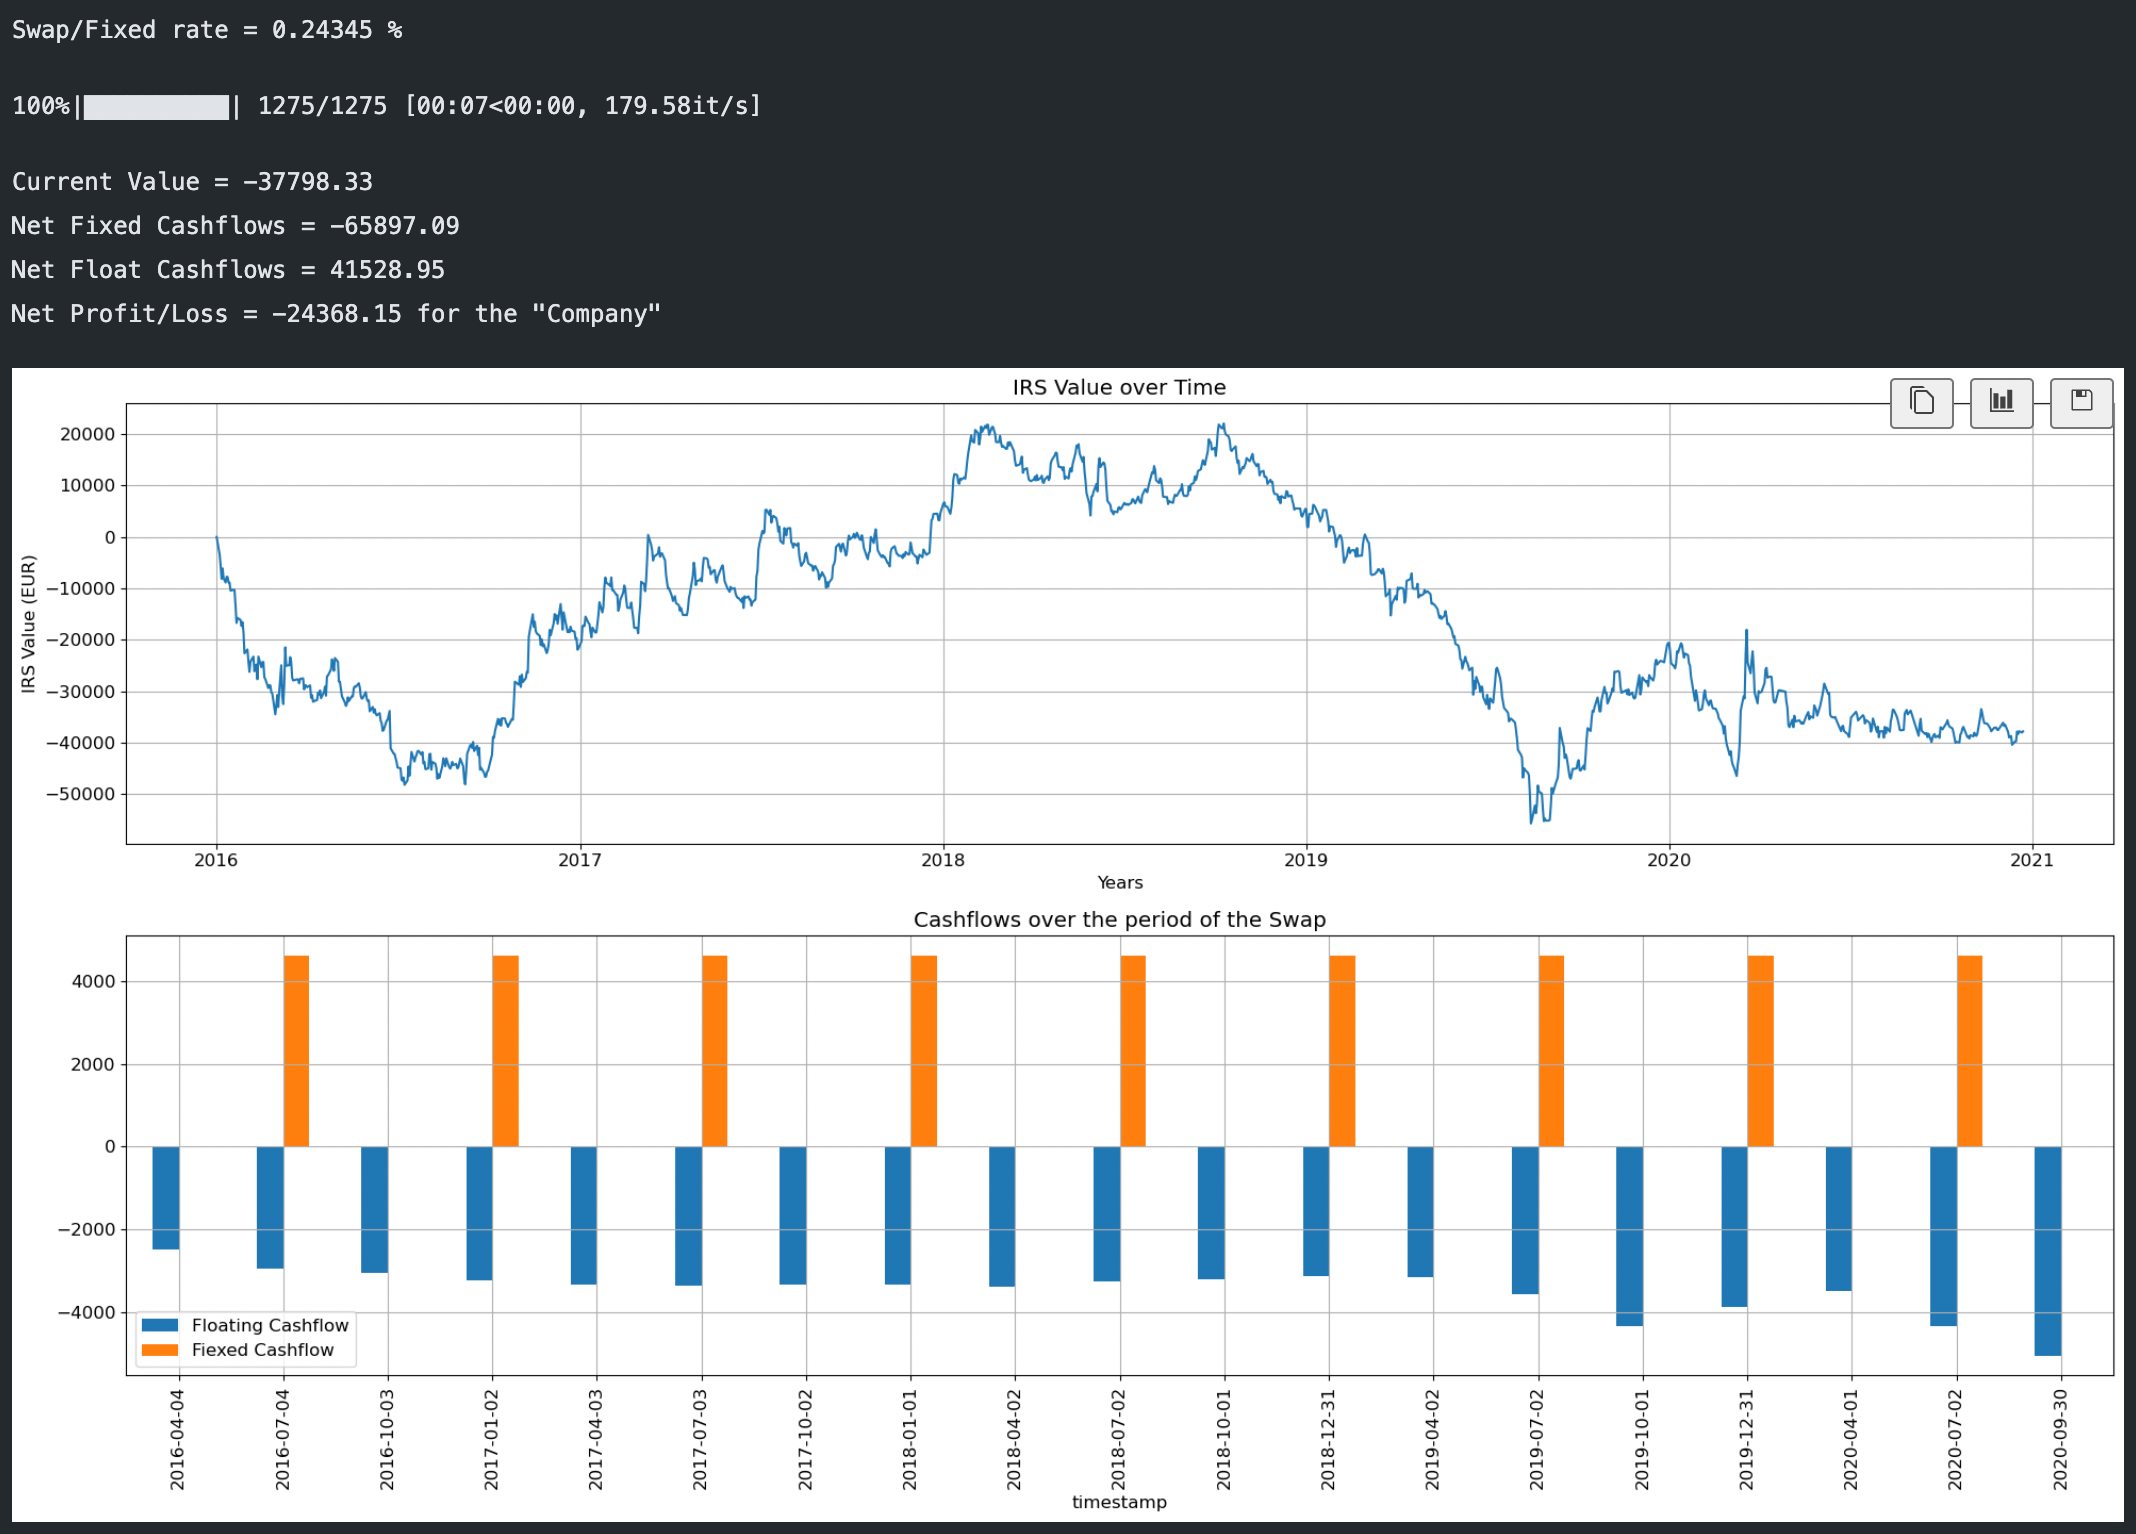

In [16]:
from IPython.display import Image
Image(filename='data/10YIRS Value over time - 2016.png')

# Vasicek Monte Carlo Simulation
$$ r(t)=r(s)e^{-k*(t-s)}+\theta\big(1-e^{-k(t-s)}\big)+\sigma\int_{s}^{t}e^{-k(t-s)}dW^0(u) $$
Where, 
$k, \sigma, \theta$ are constants

paths:     10000
periods:   365
theta = -0.0020, k = 0.02, sigma = 0.0051, r_0 = -0.0055, T = 30
intervals: 10950 days 
Total Points: 109500000
dt = 0.0027year

>>Time to simulate: 14.310sec



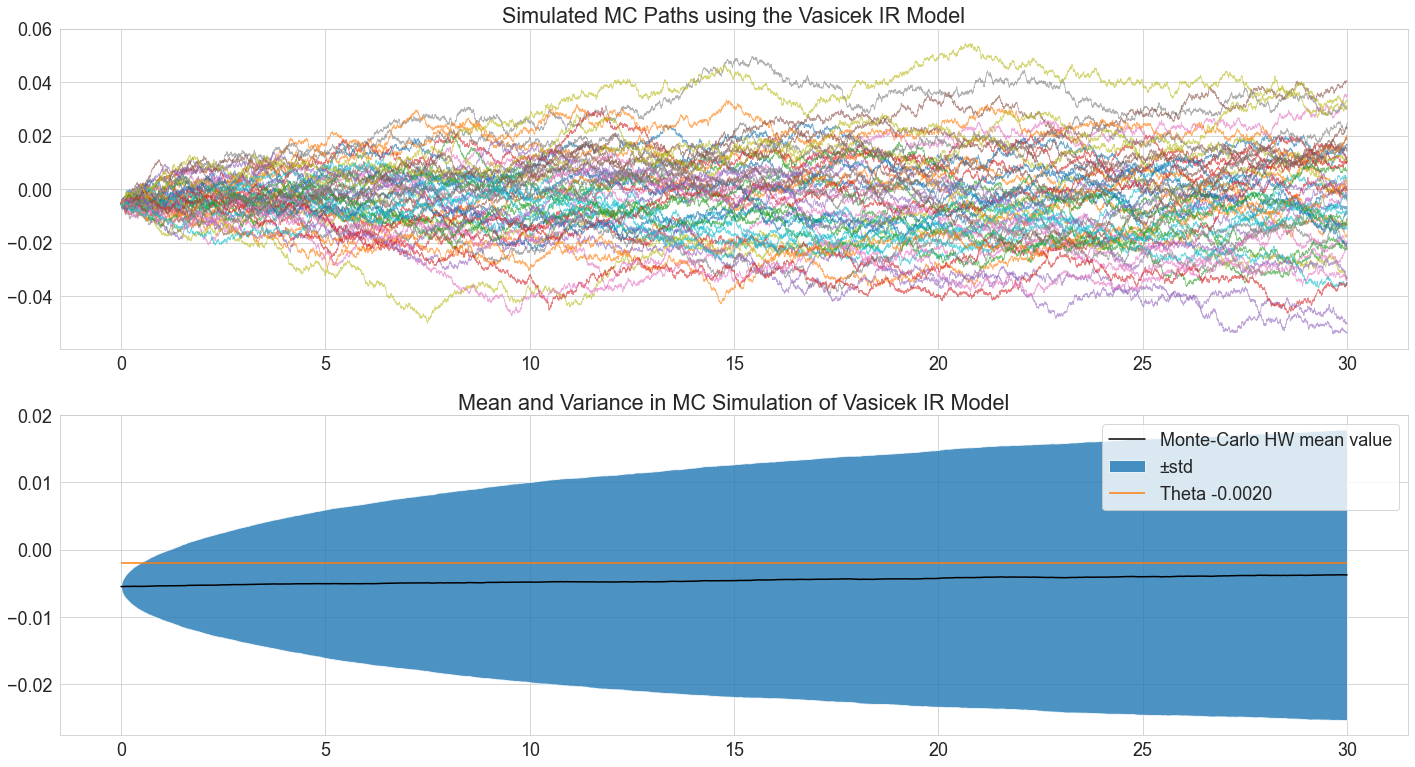

In [17]:
paths   = 10_000      ;   print(f'paths:     {paths}')
periods = 365      ;   print(f'periods:   {periods}') # Periods to simulate in a Year

theta   = df_eur3m_last.values[:,0].mean()                  # long term mean
k       = 0.02                 # speed of the mean-inversion
sigma   = 0.0051                  # Volatility 
r_0     = df_eur3m_last.values[0,0]  # Spot Interest Rates
T       = 30                    # Years - Max 30

print(f'theta = {theta:.4f}, k = {k}, sigma = {sigma}, r_0 = {r_0:.4f}, T = {T}')
""" -------------------------------------------------------------------------------------------------------------- """
intervals = T * periods    ;   print(f'intervals: {intervals} days \nTotal Points: {paths*intervals}')

_t = perf_counter()
dt = T/ intervals ; print(f'dt = {dt:.4f}year')
W = np.random.normal(loc=0.0, scale=np.sqrt(dt), size=(paths,intervals))

vas_r_t        = np.zeros(shape=(paths,intervals+1))
vas_r_t[:,0]   = r_0

@njit()
def vasicek_short_rt(vas_r_t, W):
    for i in range(intervals):
        vas_r_t[:,i+1] = vas_r_t[:,i]*np.exp(-k*dt) + theta*(1-np.exp(-k*dt)) + sigma*np.exp(-k*dt)*W[:,i]
    return vas_r_t

vas_r_t = vasicek_short_rt(vas_r_t, W)
print(f'\n>>Time to simulate: {perf_counter()-_t:.3f}sec')

fig, axs = plt.subplots(2)
index = np.linspace(start=0, stop=T, num=intervals+1, endpoint=True)
hv = pd.DataFrame( vas_r_t.T, index=index)
hv.sample(50, axis=1).plot(alpha=.6, lw=.8, legend=False, title='Simulated MC Paths using the Vasicek IR Model', grid=True, ax=axs[0])
hv.mean(axis=1).plot(figsize=(20,11),legend=False, title='Mean and Variance in MC Simulation of Vasicek IR Model', grid=True, ax=axs[1], color='black')
axs[1].fill_between(hv.index.values, hv.mean(axis=1)-hv.std(axis=1), hv.mean(axis=1)+hv.std(axis=1), alpha=.8)
axs[1].hlines(theta, 0, T,'tab:orange')
axs[1].legend(['Monte-Carlo HW mean value', '±std', f'Theta {theta:.4f}'])
del vas_r_t    ;   gc.collect()    ; print()
if SAVE_CHARTS: plt.savefig('Charts/Appendix. Vasicek MC Paths.pdf')